Generate Cubes

In [1]:
#Import libraries

import ee 
import geemap
import xee
import xarray as xr
import datetime
import rioxarray as rxr
import pandas as pd
import matplotlib.pyplot as plt
import os
import ipyleaflet
import gdown
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np, gc
import json
from osgeo import gdal, ogr, osr

gdal.UseExceptions()

In [2]:
#Authenticate/initialize earth engine
ee.Authenticate()


True

In [4]:
ee.Initialize(
    project = 'sar-testing-472822',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

In [2]:
#Set imageCollection resolution (meter projection)
res = 100
RGI_shapefile_path = "C:/Users/jaden/Downloads/Research/Glaciers/RGI2000-v7.0-G-01_alaska"
band = 'VH'

In [9]:
# Load US States from TIGER dataset
states = ee.FeatureCollection("TIGER/2018/States")

# Filter for Alaska
alaska = states.filter(ee.Filter.eq('NAME', 'Alaska')).first()

# Get geometry of Alaska
alaska_geometry = alaska.geometry()

In [ ]:
#Get GRD images (VH)
path = 14 #set path, same as ASF number
frame = 5 #set frame [WIP], requires trial and error to determine the correct correspondence
#https://forum.earthdata.nasa.gov/viewtopic.php?t=4161 for more info
img_vv = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterBounds(alaska_geometry)
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', band))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.eq('relativeOrbitNumber_start', path))
    .filter(ee.Filter.eq('sliceNumber', frame))
    .select(band)
)
crs = img_vv.first().projection().crs().getInfo()
print(f"Projection: {crs}")
#reproject to lower resolution
def downsample(img):
    # Reduce resolution using mean reducer
    return img.resample('bilinear').reproject(
        crs=crs,
        scale=res
    )

img_vv = img_vv.map(downsample)
# Extract distinct sliceNumbers for trial/error finding correct frame

data_window = ee.Filter.date('2016-01-01', '2025-01-01')
path_numbers = (img_vv
                .aggregate_array("relativeOrbitNumber_start")
                .distinct()
                .sort())
img_vv = img_vv.filter(data_window)
numImgs = img_vv.size().getInfo()
print("Distinct paths:", path_numbers.getInfo())
print("Number of images:", numImgs)


Projection: EPSG:32607
Distinct paths: [14]
Number of images: 226


In [12]:
#Get bounds of union of image collection data
footprint_union = img_vv.geometry().dissolve()

#display data sample
vis_params = {
    'min': -25,
    'max': 5,
    'palette': ['black', 'blue', 'white']
}
grd_map = geemap.Map()
grd_map.addLayer(footprint_union, {'color': 'red'}, 'S1 Footprint Union')
grd_map.addLayer(img_vv.first(), vis_params, 'GRD')
grd_map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

In [13]:
#get glac data and clip:
full_rgi = (
    ee.FeatureCollection("projects/sat-io/open-datasets/RGI/RGI_VECTOR_MERGED_V7") 
    .filter(ee.Filter.contains(leftValue=footprint_union, rightField='.geo'))
    .filter(ee.Filter.gt("area_km2", 20)) #filter for glaciers bigger than 20 km^2
)
ids = full_rgi.aggregate_array('rgi_id').getInfo() 
print(full_rgi.size().getInfo())
print(ids)

grd_map.addLayer(full_rgi, {"color": "red"}, "Clipping Geometry")
grd_map

52
['RGI2000-v7.0-G-01-06047', 'RGI2000-v7.0-G-01-06369', 'RGI2000-v7.0-G-01-05959', 'RGI2000-v7.0-G-01-05966', 'RGI2000-v7.0-G-01-06004', 'RGI2000-v7.0-G-01-06046', 'RGI2000-v7.0-G-01-06044', 'RGI2000-v7.0-G-01-05981', 'RGI2000-v7.0-G-01-06031', 'RGI2000-v7.0-G-01-06051', 'RGI2000-v7.0-G-01-06340', 'RGI2000-v7.0-G-01-06009', 'RGI2000-v7.0-G-01-06008', 'RGI2000-v7.0-G-01-05813', 'RGI2000-v7.0-G-01-05906', 'RGI2000-v7.0-G-01-06338', 'RGI2000-v7.0-G-01-05875', 'RGI2000-v7.0-G-01-05878', 'RGI2000-v7.0-G-01-05702', 'RGI2000-v7.0-G-01-05703', 'RGI2000-v7.0-G-01-05740', 'RGI2000-v7.0-G-01-05761', 'RGI2000-v7.0-G-01-05749', 'RGI2000-v7.0-G-01-06058', 'RGI2000-v7.0-G-01-06255', 'RGI2000-v7.0-G-01-06052', 'RGI2000-v7.0-G-01-06333', 'RGI2000-v7.0-G-01-05780', 'RGI2000-v7.0-G-01-05603', 'RGI2000-v7.0-G-01-05641', 'RGI2000-v7.0-G-01-06125', 'RGI2000-v7.0-G-01-06010', 'RGI2000-v7.0-G-01-05589', 'RGI2000-v7.0-G-01-05559', 'RGI2000-v7.0-G-01-05669', 'RGI2000-v7.0-G-01-11822', 'RGI2000-v7.0-G-01-12610

Map(bottom=812.0, center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='top…

In [45]:
#Select glacier:
rgi_id_string = ids[0]

#or set manually:
rgi_id_string = 'RGI2000-v7.0-G-01-05740'
rgi_id = rgi_id_string[-8:]


selected_glac = full_rgi.filter(ee.Filter.eq('rgi_id', rgi_id_string)).first() #select only object

glac_name = selected_glac.get("glac_name").getInfo()
print("Selected glacier name:", glac_name)
print(selected_glac.geometry().bounds().getInfo())

bbox = selected_glac.geometry().bounds()
m = geemap.Map()
m.addLayer(bbox, {"color": "blue"}, "Bounding Box")
m.centerObject(bbox, 9)   # zoom to the bounding rectangle
m

Selected glacier name: Kennicott Glacier
{'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-143.39675715774564, 61.438787421307694], [-142.88196729422043, 61.438787421307694], [-142.88196729422043, 61.74921666923409], [-143.39675715774564, 61.74921666923409], [-143.39675715774564, 61.438787421307694]]]}


Map(center=[61.59382353542446, -143.13936222598272], controls=(WidgetControl(options=['position', 'transparent…

In [46]:
#generate clipped collection for that box
clipped = img_vv.map(lambda img: img.clip(bbox))
numImgs = clipped.size().getInfo()
m.addLayer(clipped.first(), vis_params, "clipped grd")
m

Map(bottom=37174.0, center=[61.59382353542446, -143.13936222598272], controls=(WidgetControl(options=['positio…

Export to Drive:

In [22]:
# Convert collection to Python list of ee.Images
clipped_img_list = clipped.toList(numImgs)

for i in range(numImgs):
    img = ee.Image(clipped_img_list.get(i))
    
    # Get system:index on the client
    img_id = img.get('system:index').getInfo()
    
    task = ee.batch.Export.image.toDrive(
        image=img,
        description=f'export_{rgi_id}_{img_id}',
        folder=f'GRD_{rgi_id}',  # optional, Drive folder name
        fileNamePrefix=f's1_100m_{rgi_id}_{img_id}',
        region=img.geometry(),
        scale=res,
        crs=crs,
        fileFormat='GeoTIFF',
        maxPixels=1e13
    )
    task.start()
    print(f"Started export for {img_id}")

Started export for S1A_IW_GRDH_1SDV_20170604T155608_20170604T155633_016886_01C167_7DC9
Started export for S1A_IW_GRDH_1SDV_20170616T155609_20170616T155634_017061_01C6CC_6A55
Started export for S1A_IW_GRDH_1SDV_20170628T155609_20170628T155634_017236_01CC1A_47A5
Started export for S1A_IW_GRDH_1SDV_20170710T155610_20170710T155635_017411_01D162_56A7
Started export for S1A_IW_GRDH_1SDV_20170722T155611_20170722T155636_017586_01D6B5_4C6D
Started export for S1A_IW_GRDH_1SDV_20170803T155612_20170803T155637_017761_01DC0D_E9B1
Started export for S1A_IW_GRDH_1SDV_20170815T155612_20170815T155637_017936_01E162_6593
Started export for S1A_IW_GRDH_1SDV_20170827T155613_20170827T155638_018111_01E6AD_D46E
Started export for S1A_IW_GRDH_1SDV_20170908T155613_20170908T155638_018286_01EC04_CB36
Started export for S1A_IW_GRDH_1SDV_20170920T155614_20170920T155639_018461_01F166_2079
Started export for S1A_IW_GRDH_1SDV_20171002T155614_20171002T155639_018636_01F6CA_C2E5
Started export for S1A_IW_GRDH_1SDV_2017101

Get the DEM

In [ ]:
#Get DEM of GRD union bounds:

dem_clipped = (
    ee.ImageCollection("COPERNICUS/DEM/GLO30") 
    .filterBounds(footprint_union)
    .select('DEM')
)

single_dem = dem_clipped.mosaic().toFloat().clip(bbox)

#CMU colors
vis_params = {
    'min': 0,
    'max': 3000,
    'palette': ['black', 'white']
}

#Sanity check
centroid = footprint_union.centroid().coordinates().getInfo()
lon, lat = centroid[0], centroid[1]
dem_map = geemap.Map()
dem_map.setCenter(lon, lat, zoom=5)
dem_map.addLayer(single_dem, vis_params, 'DEM')
dem_map

Map(center=[61.60974722714133, -143.1241319938468], controls=(WidgetControl(options=['position', 'transparent_…


Sanity Checking

Export DEM

In [24]:
img = single_dem
task = ee.batch.Export.image.toDrive(
        image=img,
        description=f'export_dem',
        folder='DEM',  # optional, Drive folder name
        fileNamePrefix=f'DEM',
        region=bbox,
        scale=res,
        crs=crs,
        fileFormat='GeoTIFF',
        maxPixels=1e13
    )
task.start()
print(f"Started export dem")

Started export dem


Reformatting:

In [47]:

bounds = bbox.bounds().coordinates().get(0).getInfo()

# Get corners of bounds
xmin = int(np.min(bounds[0][0]))
ymin = int(np.min(bounds[0][1]))
xmax = int(np.max(bounds[2][0]))
ymax = int(np.max(bounds[2][1]))

print("xmin:", xmin)
print("ymin:", ymin)
print("xmax:", xmax)
print("ymax:", ymax)
# need bounds in different order for shapefile work below (minx,miny,maxx,maxy)
output_bounds = [xmin, ymin, xmax, ymax]


srcDS = gdal.OpenEx(RGI_shapefile_path)
layer = srcDS.GetLayer()
print(layer.GetName())


xmin: -143
ymin: 61
xmax: -142
ymax: 61
RGI2000-v7.0-G-01_alaska


Download files from Drive and move into tifs folder

In [48]:
cwd = os.getcwd()
tifs_path = os.path.join(cwd, 'tifs_single_glacier') #type Path
gl_path = os.path.join(tifs_path, rgi_id)
dem_path = os.path.join(gl_path, 'DEM.tif')
print(str(dem_path))
ncs_path = os.path.join(cwd, "nc")
out_nc_fn = os.path.join(ncs_path, f"out_{rgi_id}.nc")
print(out_nc_fn)


c:\Users\jaden\Downloads\Research\csv_comp\tifs_single_glacier\01-05740\DEM.tif
c:\Users\jaden\Downloads\Research\csv_comp\nc\out_01-05740.nc


In [49]:
#generate json dict

data_dict = {
    1: {
        "location_str": "Kennicott", #change later
        "scene_name": "Kennicott",
        "cube_fn": os.path.join(ncs_path, f"merged_{rgi_id}.nc"),
        #Note for jaden: 326 represents northern hemisphere, appended 06 for the specific UTM region
        "epsg_no": crs.split(":")[-1], # enter coordinate system -- pick the propoer UTM for that region (https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#)
        "path_frame_dict": {str(path): [str(frame)]}, # enter path and frame (ASF indexing used)
        "Direction": "Ascending", # enter direction
        "frame_cut": 0, # not important right now
        "pol_str" : band
    },
}

json_path = os.path.join(cwd, "dict.json")
with open(json_path, "w") as file:
    json.dump(data_dict, file, indent=4)

Move DEM and GRD tifs from Drive into local storage for next steps:

In [50]:

in_gd_dem = gdal.Open(str(dem_path))

spatial_ref = osr.SpatialReference()
spatial_ref.ImportFromWkt(in_gd_dem.GetProjection())

geotransform = in_gd_dem.GetGeoTransform()
top_left_x = geotransform[0]
pixel_width = geotransform[1]
top_left_y = geotransform[3]
pixel_height = geotransform[5]
            
# Get the number of columns and rows
cols = in_gd_dem.RasterXSize
rows = in_gd_dem.RasterYSize
            
# Calculate the extent (bounds)
xmin = top_left_x
xmax = top_left_x + (cols * pixel_width)
ymax = top_left_y
ymin = top_left_y + (rows * pixel_height)


print("xmin:", xmin)
print("ymin:", ymin)
print("xmax:", xmax)
print("ymax:", ymax)
# need bounds in different order for shapefile work below (minx,miny,maxx,maxy)
output_bounds = [xmin, ymin, xmax, ymax]
projWin=(xmin, ymax, xmax, ymin) 
print("Scene dimensions:", rows, cols)
                 

xmin: 372100.0
ymin: 6813100.0
xmax: 400700.0
ymax: 6848600.0
Scene dimensions: 355 286


In [52]:
# read RGI, make glacier id and aspect mask layers for cube
# 
# vector layer for gdal rasterize function
region_rgi_name = os.path.basename(RGI_shapefile_path)
layers = [region_rgi_name,]

xres,yres = (res,res)   # output (datacube) resolution in projection meters
resampleAlg = 'average'     # resample technique


epsg_str_for_cube = crs
# set up field definition for integer value of rgi_id
fldDef = ogr.FieldDefn('rgi_int', ogr.OFTInteger)

srcDS = gdal.OpenEx(RGI_shapefile_path)
ds = gdal.VectorTranslate('',srcDS,format = 'Memory',spatFilter=output_bounds,
                          spatSRS=epsg_str_for_cube,reproject=True,dstSRS=epsg_str_for_cube)

layer = ds.GetLayer()
layer_defn = layer.GetLayerDefn()

print("Fields available in the layer:")
for i in range(layer_defn.GetFieldCount()):
    print("-", layer_defn.GetFieldDefn(i).GetName())



#get layer and add the field:
layer = ds.GetLayer()
layer.CreateField(fldDef)


for feat in layer:
    rgi_id_str = feat.GetField('rgi_id')
    rgi_int = int(rgi_id_str.split('-')[-1])
    feat.SetField('rgi_int',rgi_int) 
    layer.SetFeature(feat) 
    

outMemRas = '/vsimem/raster_rgi_ids.tif'

gdal.Rasterize(outMemRas, ds,
               outputType=gdal.GDT_UInt32,
               outputSRS=epsg_str_for_cube,
               xRes=xres,
               yRes=yres,
#                width=XSize, height=YSize,
               outputBounds=output_bounds,
               layers=layers,
               attribute='rgi_int',
#                allTouched=True
               )
shapeRasDS = gdal.Open(outMemRas) # Open raster file in memory with gdal
rgi_ind_shape_arr = shapeRasDS.ReadAsArray() # Read into numpy array
gdal.Unlink(outMemRas)
shapeRasDS = None



outMemRas = '/vsimem/raster_aspect.tif'
print(layers)
gdal.Rasterize(outMemRas, ds,
               outputType=gdal.GDT_Float32,
               outputSRS=epsg_str_for_cube,
               xRes=xres,
               yRes=yres,
#                width=XSize, height=YSize,
               outputBounds=output_bounds,
               layers=layers,
               attribute='aspect_deg',
#                allTouched=True
               )
shapeRasDS = gdal.Open(outMemRas) # Open raster file in memory with gdal
rgi_aspect_arr = shapeRasDS.ReadAsArray() # Read into numpy array
gdal.Unlink(outMemRas)
shapeRasDS = None



Fields available in the layer:
- rgi_id
- o1region
- o2region
- glims_id
- anlys_id
- subm_id
- src_date
- cenlon
- cenlat
- utm_zone
- area_km2
- primeclass
- conn_lvl
- surge_type
- term_type
- glac_name
- is_rgi6
- termlon
- termlat
- zmin_m
- zmax_m
- zmed_m
- zmean_m
- slope_deg
- aspect_deg
- aspect_sec
- dem_source
- lmax_m
['RGI2000-v7.0-G-01_alaska']


Load GRD into cube

In [53]:

in_gd_dem = gdal.Translate('',in_gd_dem,format='VRT',projWin=projWin,xRes=xres,yRes=yres,resampleAlg=resampleAlg)

min_x,pix_x_m,r1,max_y,r2,pix_y_m = in_gd_dem.GetGeoTransform()
    
x_vec_sm = (min_x + pix_x_m/2.0) + (pix_x_m * np.arange(0,in_gd_dem.RasterXSize))
y_vec_sm = (max_y + pix_y_m/2.0) + (pix_y_m * np.arange(0,in_gd_dem.RasterYSize))
    

time_vec = np.ones((numImgs),dtype='datetime64[ns]')
    
ny,nx = in_gd_dem.RasterYSize,in_gd_dem.RasterXSize





In [54]:
out_nc_fn

'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\out_01-05740.nc'

In [55]:
folder_path = str(gl_path)

years = ['2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

#try to make it more efficient! Testing with 2017 first
for year in years:
    
    out_nc_fn_yr = os.path.join(ncs_path, f"{year}_out_{rgi_id}")
    len_good_imgs = 0
    for entry in os.listdir(folder_path):
        full_path = os.path.join(folder_path, entry)
        if ('s1' in full_path):
            date = full_path.split("_")[10][:8] #Depends on path structure!!!
            date_iso = f"{date[:4]}-{date[4:6]}-{date[6:]}"
            datetime = np.datetime64(date_iso, 'D') #day precision
            img_year = date[:4]

            if (img_year == year):
                len_good_imgs+=1
    print("Length of images in this year:" + str(len_good_imgs)) # check number of images in every year
    time_vec = np.ones((len_good_imgs),dtype='datetime64[D]')
    img_cube = np.memmap(f'1img_cube_{year}.dat', dtype='float32', mode='w+', shape=(len_good_imgs, ny, nx))
    img_cube[:] = np.nan

    count = 0
    for entry in os.listdir(folder_path):
        full_path = os.path.join(folder_path, entry)
        if ('s1' in full_path):
            print(full_path)

            date = full_path.split("_")[10][:8] #Depends on path structure!!!
            date_iso = f"{date[:4]}-{date[4:6]}-{date[6:]}"
            datetime = np.datetime64(date_iso, 'D') #day precision
            img_year = date[:4]

            if (img_year == year):
                        
                raw_gdal_img = gdal.Open(full_path)

                date = full_path.split("_")[10][:8] #Depends on path structure!!!
                date_iso = f"{date[:4]}-{date[4:6]}-{date[6:]}"
                datetime = np.datetime64(date_iso, 'D') #day precision
                #year = str(datetime.year)
                print(datetime)

                single_gd_img = gdal.Translate('', raw_gdal_img, format='VRT',
                                    projWin=projWin, xRes=xres, yRes=yres,
                                    resampleAlg=resampleAlg)
                
                time_vec[count] = datetime
                img_cube[count, :, :] = single_gd_img.ReadAsArray()

                
        
                ds = xr.Dataset(
                        data_vars = dict(
                                            images=(["time","y","x"],img_cube),
                                            dem = (["y","x"],in_gd_dem.ReadAsArray()),
                                            rgi_ind_glacier_mask = (["y","x"],rgi_ind_shape_arr),
                                            rgi_aspect_arr = (["y","x"],rgi_aspect_arr),
                                        ),
                        coords = dict(
                                        time = time_vec,
                                        x = x_vec_sm,
                                        y = y_vec_sm,
                                    ),
                        attrs=dict(
                                        description=f"Sentinel 1 SAR (RTC Gamma processed) count {count}",
                                        projection = epsg_str_for_cube,
                                        epsg_str = epsg_str_for_cube,
                                        geotransform = single_gd_img.GetGeoTransform()
                                ),
                )
                if os.path.exists(out_nc_fn_yr):
                    os.remove(out_nc_fn_yr)
                ds.to_netcdf(out_nc_fn_yr)
                ds.close()

                # %%
                

                count += 1

Length of images in this year:18
c:\Users\jaden\Downloads\Research\csv_comp\tifs_single_glacier\01-05740\s1_100m_01-05740_S1A_IW_GRDH_1SDV_20170604T155608_20170604T155633_016886_01C167_7DC9.tif
2017-06-04
c:\Users\jaden\Downloads\Research\csv_comp\tifs_single_glacier\01-05740\s1_100m_01-05740_S1A_IW_GRDH_1SDV_20170616T155609_20170616T155634_017061_01C6CC_6A55.tif
2017-06-16
c:\Users\jaden\Downloads\Research\csv_comp\tifs_single_glacier\01-05740\s1_100m_01-05740_S1A_IW_GRDH_1SDV_20170628T155609_20170628T155634_017236_01CC1A_47A5.tif
2017-06-28
c:\Users\jaden\Downloads\Research\csv_comp\tifs_single_glacier\01-05740\s1_100m_01-05740_S1A_IW_GRDH_1SDV_20170710T155610_20170710T155635_017411_01D162_56A7.tif
2017-07-10
c:\Users\jaden\Downloads\Research\csv_comp\tifs_single_glacier\01-05740\s1_100m_01-05740_S1A_IW_GRDH_1SDV_20170722T155611_20170722T155636_017586_01D6B5_4C6D.tif
2017-07-22
c:\Users\jaden\Downloads\Research\csv_comp\tifs_single_glacier\01-05740\s1_100m_01-05740_S1A_IW_GRDH_1SDV_2

Check for time overlap before merge:

In [56]:
# list of yearly NetCDF files
files = []
for year in years:
    file_str = str(os.path.join(ncs_path, f"{year}_out_{rgi_id}"))
    files.append(file_str)
print(files)

last_times = []
first_times = []

for f in files:
    ds = xr.open_dataset(f)
    t = ds["time"].values
    first_times.append(t[0])
    last_times.append(t[-1])

for i in range(len(files)-1):
    print(f"{files[i]} last: {last_times[i]}")
    print(f"{files[i+1]} first: {first_times[i+1]}")
    if last_times[i] >= first_times[i+1]:
        print("⚠️ Overlap detected!\n")
    else:
        print("✓ No overlap\n")

['c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\2017_out_01-05740', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\2018_out_01-05740', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\2019_out_01-05740', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\2020_out_01-05740', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\2021_out_01-05740', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\2022_out_01-05740', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\2023_out_01-05740', 'c:\\Users\\jaden\\Downloads\\Research\\csv_comp\\nc\\2024_out_01-05740']
c:\Users\jaden\Downloads\Research\csv_comp\nc\2017_out_01-05740 last: 2017-12-25T00:00:00.000000000
c:\Users\jaden\Downloads\Research\csv_comp\nc\2018_out_01-05740 first: 2018-01-06T00:00:00.000000000
✓ No overlap

c:\Users\jaden\Downloads\Research\csv_comp\nc\2018_out_01-05740 last: 2018-12-20T00:00:00.000000000
c:\Users\jaden\Downloads\Research\csv_comp\nc\2019_out_01-05740 first: 2019-01-01T00:00:00.0

In [57]:
#Vertically join netcdf datasets

ds_all = xr.open_mfdataset(
    files,
    combine="by_coords",  # stack by coordinate values
    parallel=True          # optional: faster if dask is available
)

# Save merged dataset
ds_all = ds_all.chunk({"time":50})
merged_nc_path = os.path.join(ncs_path, f"merged_{rgi_id}.nc")
if os.path.exists(merged_nc_path):
                    os.remove(merged_nc_path)
ds_all.to_netcdf(merged_nc_path)
ds_all.close()


Minor diagnostics (last backscatter image read, ds shape)

Text(0.5, 1.0, 'full image backscatter (last image read)')

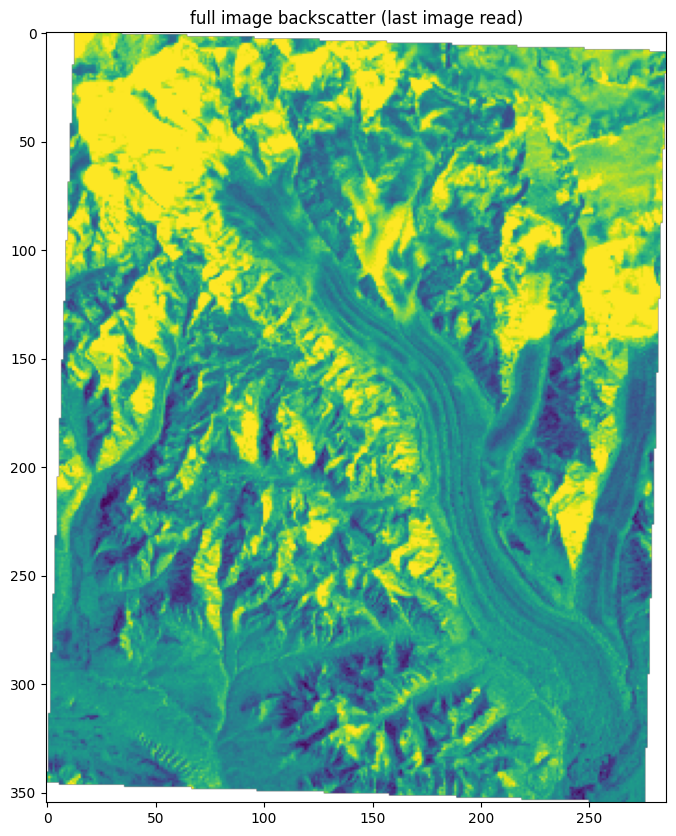

In [58]:
fig,ax = plt.subplots(1,1,figsize=[10,10])
ax.imshow(single_gd_img.ReadAsArray(),vmin=-30,vmax=-5)
ax.set_title('full image backscatter (last image read)') 

Generate parameter json

In [60]:
ds_all.images.shape

(226, 355, 286)